In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!apt-get install libmagickwand-dev
!pip install wand
!pip install torchsummary 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmagickwand-dev is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.9).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [3]:
from __future__ import print_function, division
import os
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import matplotlib.pyplot as plt
import cv2
from wand.image import Image
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
assert torch.cuda.is_available(), 'GPU unavailable'

In [5]:
!nvidia-smi

Sat May  8 23:21:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
print('Number of GPUs available : ', torch.cuda.device_count())

Number of GPUs available :  1


In [7]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


# Data Load and Augmentation

In [8]:
PATH_DIR = '/content/drive/MyDrive/ML-MicroNet/'

In [9]:
def load_images_from_folder(files):
  images = []
  images_gt = []
  for filename in files:
    filename_gt = filename.split('.')[0] + '_annot.bmp'
    img = cv2.imread(os.path.join(PATH_DIR + 'dataset/train-X/', filename))
    img_gt = cv2.imread(os.path.join(PATH_DIR + 'dataset/train-Y/', filename_gt))
    if (img is not None) and (img_gt is not None):
      images.append(img)
      images_gt.append(img_gt)
  return images, images_gt

In [10]:
files = os.listdir(PATH_DIR + 'dataset/train-X')

In [11]:
# Load training images and ground truth.

training_imgs, training_imgs_gt = load_images_from_folder(files)

(522, 775, 3) <class 'numpy.ndarray'>


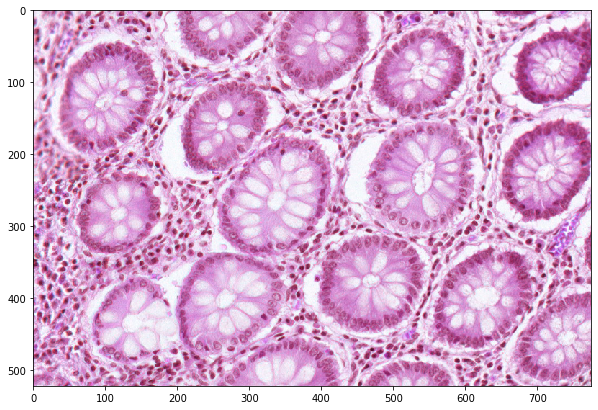

In [12]:
print(training_imgs[81].shape, type(training_imgs[81]))
plt.imshow(training_imgs[81])
plt.show()

(522, 775, 3) <class 'numpy.ndarray'>


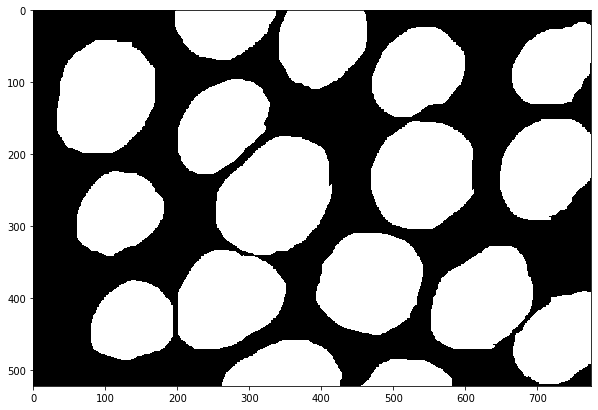

In [13]:
print(training_imgs_gt[81].shape, type(training_imgs_gt[81]))
plt.imshow(training_imgs_gt[81])
plt.show()

In [14]:
print('Number of training examples : ', len(training_imgs))
print('Number of ground truth examples : ', len(training_imgs_gt))

Number of training examples :  85
Number of ground truth examples :  85


Data Augmentation

Effect 1 : Add barrel distortion.<br>Image magnification decreases with distance from the optical axis.

In [15]:
barrel_distorted_imgs = []
barrel_distorted_imgs_gt = []

folder1 = PATH_DIR + 'dataset/train-X'
folder2 = PATH_DIR + 'dataset/train-Y'
for f in files:
  file_gt = f.split('.')[0] + '_annot.bmp'
  with Image(filename=os.path.join(folder1, f)) as img1, Image(filename=os.path.join(folder2, file_gt)) as img2:
    barrel_distorted_imgs_gt.append(np.array(img2))
    img1.virtual_pixel = 'mirror'
    img1.distort('barrel', (0.02, 0.0, 0.0, 1.0))
    barrel_distorted_imgs.append(np.array(img1))

(522, 775, 3) <class 'numpy.ndarray'>


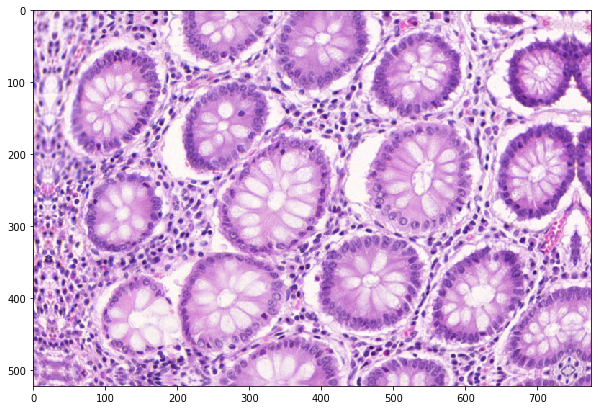

In [16]:
print(barrel_distorted_imgs[81].shape, type(barrel_distorted_imgs[81]))
plt.imshow(barrel_distorted_imgs[81])
plt.show()

Effect 2 : Add pincushion distortion.<br>Image magnification increases with the distance from the optical axis.

In [17]:
pincushion_distorted_imgs = []
pincushion_distorted_imgs_gt = []

folder1 = PATH_DIR + 'dataset/train-X'
folder2 = PATH_DIR + 'dataset/train-Y'
for f in files:
  file_gt = f.split('.')[0] + '_annot.bmp'
  with Image(filename=os.path.join(folder1, f)) as img1, Image(filename=os.path.join(folder2, file_gt)) as img2:
    pincushion_distorted_imgs_gt.append(np.array(img2))
    img1.virtual_pixel = 'mirror'
    img1.distort('barrel_inverse', (0.02, 0.0, 0.0, 1.0))
    pincushion_distorted_imgs.append(np.array(img1))

(522, 775, 3) <class 'numpy.ndarray'>


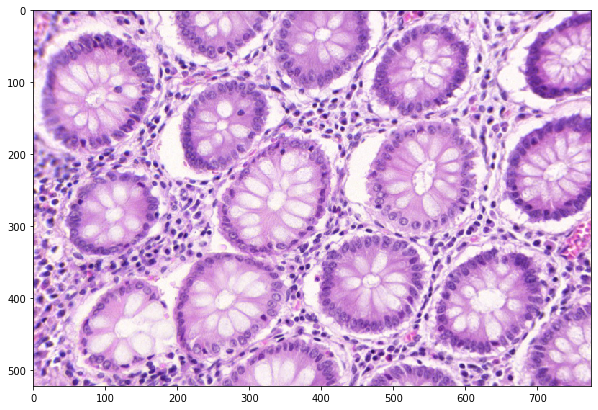

In [18]:
print(pincushion_distorted_imgs[81].shape, type(pincushion_distorted_imgs[81]))
plt.imshow(pincushion_distorted_imgs[81])
plt.show()

Effect 3 : Add mustache distortion.<br>Starts out as barrel distortion close to the image center, and<br>gradually turns into pincushion distortion towards the image periphery.

In [19]:
mustache_distorted_imgs = []
mustache_distorted_imgs_gt = []

folder1 = PATH_DIR + 'dataset/train-X'
folder2 = PATH_DIR + 'dataset/train-Y'
for f in files:
  file_gt = f.split('.')[0] + '_annot.bmp'
  with Image(filename=os.path.join(folder1, f)) as img1, Image(filename=os.path.join(folder2, file_gt)) as img2:
    mustache_distorted_imgs_gt.append(np.array(img2))
    img1.virtual_pixel = 'mirror'
    img1.distort('barrel', (0.08, 0.0, 0.0, 1.0))
    img1.distort('barrel_inverse', (0.04, 0.0, 0.0, 1.0))
    mustache_distorted_imgs.append(np.array(img1))

(522, 775, 3) <class 'numpy.ndarray'>


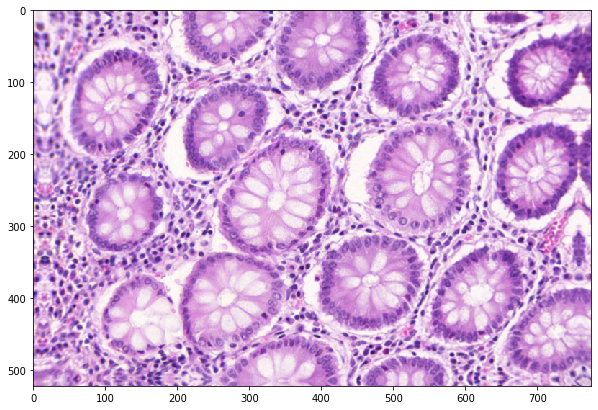

In [20]:
print(mustache_distorted_imgs[81].shape, type(mustache_distorted_imgs[81]))
plt.imshow(mustache_distorted_imgs[81])
plt.show()

Effects 4 to 22 : Add Gaussian blur.<br>Gaussian filter of size 12 × 12, with σ ranging from 0.2 to 2

In [21]:
gaussian_blurred_images = []
gaussian_blurred_images_gt = []

for idx, img in enumerate(training_imgs):
  img_gt = training_imgs_gt[idx]
  for i in range(2, 21):
    sigma = round(i*0.1, 2)
    blurred_img = cv2.GaussianBlur(img, (11, 11), sigma)
    gaussian_blurred_images.append(np.array(blurred_img))
    gaussian_blurred_images_gt.append(np.array(img_gt))

(522, 775, 3) <class 'numpy.ndarray'>


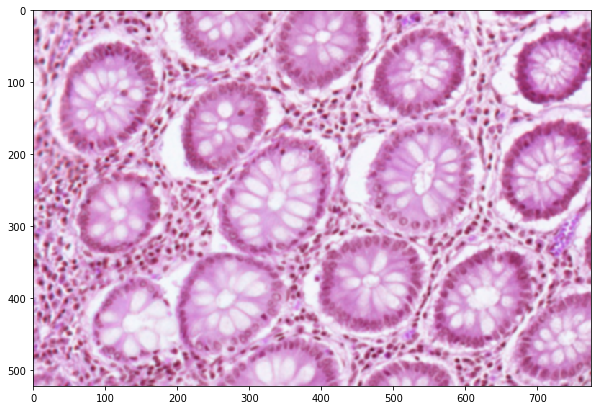

In [22]:
print(gaussian_blurred_images[81*19+10].shape, type(gaussian_blurred_images[81*19+10]))
plt.imshow(gaussian_blurred_images[81*19+10])
plt.show()

Effects 23 to 25 : Rotate left (270 degrees), right (90 degrees), up and down (180 degrees)

In [23]:
def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

In [24]:
rotated_90_images = []
rotated_90_images_gt = []
rotated_180_images = []
rotated_180_images_gt = []
rotated_270_images = []
rotated_270_images_gt = []

for idx, img in enumerate(training_imgs):
  img_gt = training_imgs_gt[idx]

  rotated_90_images.append(np.array(rotate_image(img, 90)))
  rotated_90_images_gt.append(np.array(rotate_image(img_gt, 90)))

  rotated_180_images.append(np.array(rotate_image(img, 180)))
  rotated_180_images_gt.append(np.array(rotate_image(img_gt, 180)))

  rotated_270_images.append(np.array(rotate_image(img, 270)))
  rotated_270_images_gt.append(np.array(rotate_image(img_gt, 270)))

(775, 522, 3) <class 'numpy.ndarray'>


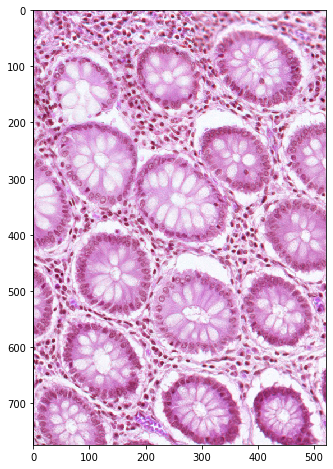

In [25]:
print(rotated_270_images[81].shape, type(rotated_270_images[81]))
plt.imshow(rotated_270_images[81])
plt.show()

(775, 522, 3) <class 'numpy.ndarray'>


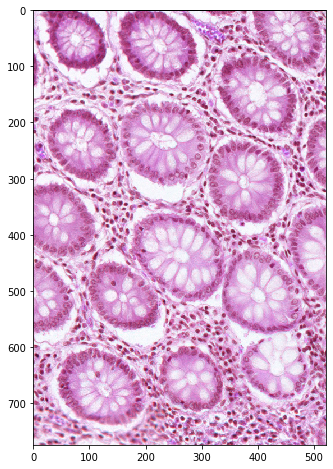

In [26]:
print(rotated_90_images[81].shape, type(rotated_90_images[81]))
plt.imshow(rotated_90_images[81])
plt.show()

(522, 775, 3) <class 'numpy.ndarray'>


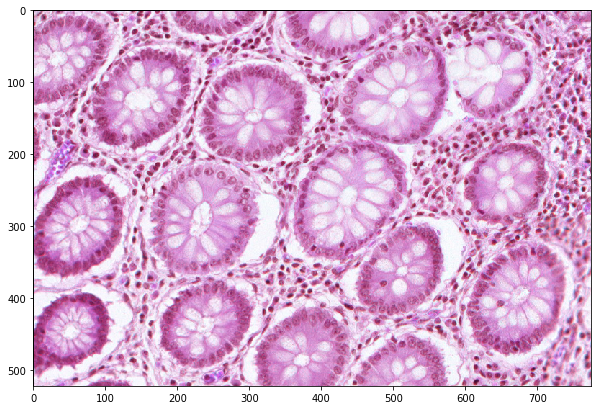

In [27]:
print(rotated_180_images[81].shape, type(rotated_180_images[81]))
plt.imshow(rotated_180_images[81])
plt.show()

Effects 26 to 28 : Flip left, right, up and down

In [28]:
flipped_x_axis_images = []
flipped_x_axis_images_gt = []
flipped_y_axis_images = []
flipped_y_axis_images_gt = []
flipped_both_axes_images = []
flipped_both_axes_images_gt = []

for idx, img in enumerate(training_imgs):
  img_gt = training_imgs_gt[idx]

  flipped_x_axis_images.append(np.array(cv2.flip(img, 0)))
  flipped_x_axis_images_gt.append(np.array(cv2.flip(img_gt, 0)))

  flipped_y_axis_images.append(np.array(cv2.flip(img, 1)))
  flipped_y_axis_images_gt.append(np.array(cv2.flip(img_gt, 1)))

  flipped_both_axes_images.append(np.array(cv2.flip(img, -1)))
  flipped_both_axes_images_gt.append(np.array(cv2.flip(img_gt, -1)))

(522, 775, 3) <class 'numpy.ndarray'>


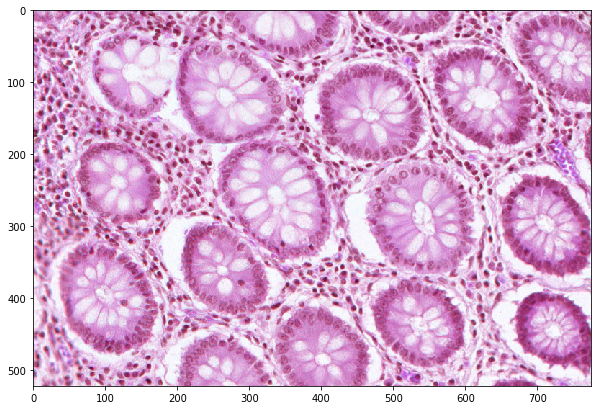

In [29]:
print(flipped_x_axis_images[81].shape, type(flipped_x_axis_images[81]))
plt.imshow(flipped_x_axis_images[81])
plt.show()

(522, 775, 3) <class 'numpy.ndarray'>


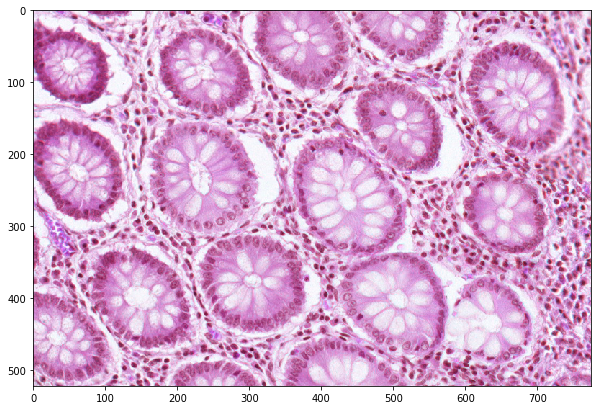

In [30]:
print(flipped_y_axis_images[81].shape, type(flipped_y_axis_images[81]))
plt.imshow(flipped_y_axis_images[81])
plt.show()

(522, 775, 3) <class 'numpy.ndarray'>


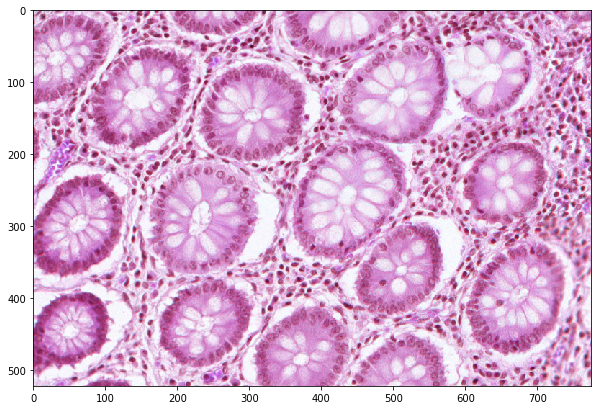

In [31]:
print(flipped_both_axes_images[81].shape, type(flipped_both_axes_images[81]))
plt.imshow(flipped_both_axes_images[81])
plt.show()

Collect augmented data

In [32]:
X_train = training_imgs \
+ barrel_distorted_imgs \
+ pincushion_distorted_imgs \
+ mustache_distorted_imgs \
+ gaussian_blurred_images \
+ rotated_90_images \
+ rotated_180_images \
+ rotated_270_images \
+ flipped_x_axis_images \
+ flipped_y_axis_images \
+ flipped_both_axes_images

In [33]:
Y_train = training_imgs_gt \
+ barrel_distorted_imgs_gt \
+ pincushion_distorted_imgs_gt \
+ mustache_distorted_imgs_gt \
+ gaussian_blurred_images_gt \
+ rotated_90_images_gt \
+ rotated_180_images_gt \
+ rotated_270_images_gt \
+ flipped_x_axis_images_gt \
+ flipped_y_axis_images_gt \
+ flipped_both_axes_images_gt

In [34]:
print('After data augmentation...')
print('Number of training examples : ', len(X_train))
print('Number of ground truth examples : ', len(Y_train))

After data augmentation...
Number of training examples :  2465
Number of ground truth examples :  2465


# Data Preparation

Create Dataset

In [35]:
class CustomDataset(Dataset):
    def __init__(self, X_list, Y_list):
      self.X = X_list
      self.Y = Y_list
    
    def __len__(self):
      return len(self.Y)
   
    def __getitem__(self, index):
      return self.X[index], self.Y[index]

In [36]:
# create a dataset object
dset = CustomDataset(X_train, Y_train)

Create train and validation splits

In [37]:
# 90%-10% train-validation split

validation_split = 0.1
dataset_size = len(dset)
indices = list(range(dataset_size))
validation_size = int(np.floor(validation_split * dataset_size))
train_size = dataset_size - validation_size

# create DataLoader for train and validation sets
train_set, validation_set = torch.utils.data.random_split(dset, [train_size, validation_size])
train_loader = DataLoader(train_set, batch_size = 1, num_workers = 2)
validation_loader = DataLoader(validation_set, batch_size = 1, num_workers = 2)

# Micro-Net-508

Group 1: Downsampling

In [38]:
class Group1Block(nn.Module):
  
  def __init__(self, conv_in_channels, conv_out_channels, conv_kernel_sizes, pool_kernel_size):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=conv_in_channels[0], out_channels=conv_out_channels[0], kernel_size=conv_kernel_sizes[0])
    self.conv2 = nn.Conv2d(in_channels=conv_in_channels[1], out_channels=conv_out_channels[1], kernel_size=conv_kernel_sizes[1])
    self.conv3 = nn.Conv2d(in_channels=conv_in_channels[2], out_channels=conv_out_channels[2], kernel_size=conv_kernel_sizes[2])
    self.conv4 = nn.Conv2d(in_channels=conv_in_channels[3], out_channels=conv_out_channels[3], kernel_size=conv_kernel_sizes[3])
    self.tanh = nn.Tanh()
    self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size)

  def forward(self, input_prev, residual):
    x = self.conv1(input_prev)
    x = self.tanh(x)
    x = self.conv2(x)
    x = self.tanh(x)
    x = self.pool(x)

    y = torch.nn.functional.interpolate(residual, size=[x.shape[2], x.shape[3]], mode='bicubic', align_corners=True)
    y = self.conv3(y)
    y = self.tanh(y)
    y = self.conv4(y)
    y = self.tanh(y)

    out = torch.cat([x, y], dim=1)
    
    return out

Group 2: Bridge

In [39]:
class Group2Block1(nn.Module):
  
  def __init__(self, conv_in_channels, conv_out_channels, conv_kernel_sizes, pool_kernel_size):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=conv_in_channels[0], out_channels=conv_out_channels[0], kernel_size=conv_kernel_sizes[0])
    self.conv2 = nn.Conv2d(in_channels=conv_in_channels[1], out_channels=conv_out_channels[1], kernel_size=conv_kernel_sizes[1])
    self.conv3 = nn.Conv2d(in_channels=conv_in_channels[2], out_channels=conv_out_channels[2], kernel_size=conv_kernel_sizes[2])
    self.conv4 = nn.Conv2d(in_channels=conv_in_channels[3], out_channels=conv_out_channels[3], kernel_size=conv_kernel_sizes[3])
    self.tanh = nn.Tanh()
    self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size)

  def forward(self, input):
    x = self.conv1(input)
    x = self.tanh(x)
    x = self.conv2(x)
    x = self.tanh(x)
    x = self.pool(x)
    x = self.conv3(x)
    x = self.tanh(x)
    x = self.conv4(x)
    out = self.tanh(x)

    return out

In [40]:
class Group2Block2(nn.Module):
  
  def __init__(self, tconv_in_channels, tconv_out_channels, conv_in_channels, conv_out_channels, tconv_kernel_sizes, conv_kernel_sizes):
    super().__init__()

    self.tconv1 = nn.ConvTranspose2d(in_channels=tconv_in_channels[0], out_channels=tconv_out_channels[0], kernel_size=tconv_kernel_sizes[0])
    self.tconv2 = nn.ConvTranspose2d(in_channels=tconv_in_channels[1], out_channels=tconv_out_channels[1], kernel_size=tconv_kernel_sizes[1])
    self.conv1 = nn.Conv2d(in_channels=conv_in_channels[0], out_channels=conv_out_channels[0], kernel_size=conv_kernel_sizes[0])
    self.conv2 = nn.Conv2d(in_channels=conv_in_channels[1], out_channels=conv_out_channels[1], kernel_size=conv_kernel_sizes[1])
    self.tanh = nn.Tanh()

  def forward(self, input):
    x = self.tconv1(input)
    x = self.conv1(x)
    x = self.tanh(x)
    x = self.conv2(x)
    x = self.tanh(x)
    out = self.tconv2(x)

    return out

Group 3: Upsampling

In [41]:
class Group3Block(nn.Module):
  
  def __init__(self, tconv_in_channels, tconv_out_channels, conv_in_channels, conv_out_channels, tconv_kernel_sizes, conv_kernel_sizes):
    super().__init__()

    self.tconv1 = nn.ConvTranspose2d(in_channels=tconv_in_channels[0], out_channels=tconv_out_channels[0], kernel_size=tconv_kernel_sizes[0])
    self.tconv2 = nn.ConvTranspose2d(in_channels=tconv_in_channels[1], out_channels=tconv_out_channels[1], kernel_size=tconv_kernel_sizes[1])
    self.tconv3 = nn.ConvTranspose2d(in_channels=tconv_in_channels[2], out_channels=tconv_out_channels[2], kernel_size=tconv_kernel_sizes[2])
    self.conv1 = nn.Conv2d(in_channels=conv_in_channels[0], out_channels=conv_out_channels[0], kernel_size=conv_kernel_sizes[0])
    self.conv2 = nn.Conv2d(in_channels=conv_in_channels[1], out_channels=conv_out_channels[1], kernel_size=conv_kernel_sizes[1])
    self.conv3 = nn.Conv2d(in_channels=conv_in_channels[2], out_channels=conv_out_channels[2], kernel_size=conv_kernel_sizes[2])
    self.tanh = nn.Tanh()

  def forward(self, input_prev, residual):
    x = self.tconv1(input_prev)
    x = self.conv1(x)
    x = self.tanh(x)
    x = self.conv2(x)
    x = self.tanh(x)
    x = self.tconv2(x)

    y = self.tconv3(residual)
    
    out = torch.cat([x, y], dim=1)
    out = self.conv3(out)
    out = self.tanh(out)
    
    return out

Group 4 : Auxiliary Outputs

In [42]:
class Group4Block(nn.Module):
  
  def __init__(self, tconv_in_channels, tconv_out_channels, conv_in_channels, conv_out_channels, 
               tconv_kernel_size, tconv_stride, conv_kernel_sizes, drop_rate):
    super().__init__()

    self.tconv = nn.ConvTranspose2d(in_channels=tconv_in_channels, out_channels=tconv_out_channels, kernel_size=tconv_kernel_size, stride=tconv_stride)
    self.conv1 = nn.Conv2d(in_channels=conv_in_channels[0], out_channels=conv_out_channels[0], kernel_size=conv_kernel_sizes[0])
    self.conv2 = nn.Conv2d(in_channels=conv_in_channels[1], out_channels=conv_out_channels[1], kernel_size=conv_kernel_sizes[1])
    self.tanh = nn.Tanh()
    self.drop = nn.Dropout(p=drop_rate)
    self.softmax = torch.nn.Softmax2d()

  def forward(self, input):
    x = self.tconv(input)
    x = self.conv1(x)
    feature_mask = self.tanh(x)

    y = self.drop(feature_mask)
    y = self.conv2(y)
    y = self.tanh(y)
   
    probs = self.softmax(y)

    return probs, feature_mask
  
  def predict(self, input):
    x = self.tconv(input)
    x = self.conv1(x)
    feature_mask = self.tanh(x)

    return feature_mask

Group 5 : Main Output

In [43]:
class Group5Block(nn.Module):
  
  def __init__(self, conv_in_channels, conv_out_channels, conv_kernel_size, drop_rate):
    super().__init__()

    self.conv = nn.Conv2d(in_channels=conv_in_channels, out_channels=conv_out_channels, kernel_size=conv_kernel_size)
    self.tanh = nn.Tanh()
    self.drop = nn.Dropout(p=drop_rate)
    self.softmax = torch.nn.Softmax2d()

  def forward(self, input1, input2, input3):
    x = torch.cat([input1, input2, input3], dim=1)
    x = self.drop(x)
    x = self.conv(x)
    out_img = self.tanh(x)
    probs = self.softmax(out_img)

    return probs
  
  def predict(self, input1, input2, input3):
    x = torch.cat([input1, input2, input3], dim=1)
    x = self.drop(x)
    x = self.conv(x)
    out_img = self.tanh(x)
    probs = self.softmax(out_img)

    return probs

Model

In [44]:
class MicroNet(nn.Module):
  
  def __init__(self):
    super().__init__()

    # Group 1 blocks
    group1 = []
    for i in range(4):
      if i == 0:
        block = Group1Block(conv_in_channels=[3, 64, 3, 64], 
                            conv_out_channels=[64, 64, 64, 64], 
                            conv_kernel_sizes=[3, 3, 1, 1], 
                            pool_kernel_size=2)
      if i == 1:
        block = Group1Block(conv_in_channels=[128, 124, 3, 128], 
                            conv_out_channels=[124, 128, 128, 128], 
                            conv_kernel_sizes=[3, 3, 1, 1], 
                            pool_kernel_size=2)
      if i == 2:
        block = Group1Block(conv_in_channels=[256, 256, 3, 256], 
                            conv_out_channels=[256, 256, 256, 256], 
                            conv_kernel_sizes=[3, 3, 1, 1], 
                            pool_kernel_size=2)
      if i == 3:
        block = Group1Block(conv_in_channels=[512, 512, 3, 512], 
                            conv_out_channels=[512, 512, 512, 512], 
                            conv_kernel_sizes=[3, 3, 1, 1], 
                            pool_kernel_size=2)
      group1.append(block)
    self.group1 = nn.ModuleList(group1)

    # Group 2 blocks
    self.group2block1 = Group2Block1(conv_in_channels=[1024, 1024, 1024, 2048], 
                                     conv_out_channels=[1024, 1024, 2048, 2048], 
                                     conv_kernel_sizes=[3, 3, 3, 3], 
                                     pool_kernel_size=2)
    self.group2block2 = Group2Block2(tconv_in_channels=[2048, 2048], 
                                     tconv_out_channels=[2048, 2048], 
                                     conv_in_channels=[2048, 2048], 
                                     conv_out_channels=[2048, 2048], 
                                     tconv_kernel_sizes=[5, 5], 
                                     conv_kernel_sizes=[1, 1])

    # Group 3 blocks
    group3 = []
    for i in range(4):
      if i == 0:
        block = Group3Block(tconv_in_channels=[2048, 1024, 1024], 
                            tconv_out_channels=[2048, 1024, 1024], 
                            conv_in_channels=[2048, 1024, 2048], 
                            conv_out_channels=[1024, 1024, 1024], 
                            tconv_kernel_sizes=[9, 9, 5], 
                            conv_kernel_sizes=[1, 1, 1])
      if i == 1:
        block = Group3Block(tconv_in_channels=[1024, 512, 512], 
                            tconv_out_channels=[1024, 512, 512], 
                            conv_in_channels=[1024, 512, 1024], 
                            conv_out_channels=[512, 512, 512], 
                            tconv_kernel_sizes=[17, 17, 5], 
                            conv_kernel_sizes=[1, 1, 1])
      if i == 2:
        block = Group3Block(tconv_in_channels=[512, 256, 256], 
                            tconv_out_channels=[512, 256, 256], 
                            conv_in_channels=[512, 256, 512], 
                            conv_out_channels=[256, 256, 256], 
                            tconv_kernel_sizes=[33, 33, 5], 
                            conv_kernel_sizes=[1, 1, 1])
      if i == 3:
        block = Group3Block(tconv_in_channels=[256, 128, 128], 
                            tconv_out_channels=[256, 128, 128], 
                            conv_in_channels=[256, 128, 256], 
                            conv_out_channels=[128, 128, 128], 
                            tconv_kernel_sizes=[65, 65, 5], 
                            conv_kernel_sizes=[1, 1, 1])
      group3.append(block)
    self.group3 = nn.ModuleList(group3)

    # Group 4 blocks
    self.group4_1 = Group4Block(tconv_in_channels=128, 
                                tconv_out_channels=64, 
                                conv_in_channels=[64, 64], 
                                conv_out_channels=[64, 3], 
                                tconv_kernel_size=2, 
                                tconv_stride=2,
                                conv_kernel_sizes=[3, 3], 
                                drop_rate=0.5)
    self.group4_2 = Group4Block(tconv_in_channels=256, 
                                tconv_out_channels=128, 
                                conv_in_channels=[128, 128], 
                                conv_out_channels=[128, 3], 
                                tconv_kernel_size=4, 
                                tconv_stride=4,
                                conv_kernel_sizes=[3, 3], 
                                drop_rate=0.5)
    self.group4_3 = Group4Block(tconv_in_channels=512, 
                                tconv_out_channels=256, 
                                conv_in_channels=[256, 256], 
                                conv_out_channels=[256, 3], 
                                tconv_kernel_size=8,
                                tconv_stride=8, 
                                conv_kernel_sizes=[3, 3], 
                                drop_rate=0.5)
    
    # Group 5 block
    self.group5 = Group5Block(conv_in_channels=448, 
                              conv_out_channels=3, 
                              conv_kernel_size=3, 
                              drop_rate=0.5)

  def forward(self, input):
    # Group 1
    B1, B2, B3, B4 = None, None, None, None
    for i, layer in enumerate(self.group1):
      if i==0:
        B1 = layer(input, input)
      elif i==1:
        B2 = layer(B1, input)
      elif i==2:
        B3 = layer(B2, input)
      elif i==3:
        B4 = layer(B3, input)

    # Group 2
    B5 = self.group2block1(B4)
    B6 = self.group2block2(B5)

    # Group 3
    B7, B8, B9, B10 = None, None, None, None
    for i, layer in enumerate(self.group3):
      if i==0:
        B7 = layer(B6, B4)
      elif i==1:
        B8 = layer(B7, B3)
      elif i==2:
        B9 = layer(B8, B2)
      elif i==3:
        B10 = layer(B9, B1)

    # Group 4
    pa1, feature_mask1 = self.group4_1(B10)
    pa2, feature_mask2 = self.group4_2(B9)
    pa3, feature_mask3 = self.group4_3(B8)

    # Group 5
    po = self.group5(feature_mask1, feature_mask2, feature_mask3)
    segmented = (po>0.5).float()
    
    # Compute auxiliary and main losses
    # The paper proposes that every logprob be multiplied by a weight function
    # of pixels. For simplicity, we do not weight logprobs here.
    la1 = torch.sum(torch.log(pa1)).item()
    la2 = torch.sum(torch.log(pa2)).item()
    la3 = torch.sum(torch.log(pa3)).item()
    lo = torch.sum(torch.log(po)).item()
      
    return la1, la2, la3, lo, segmented
  
  def predict(self, TODO):
    # Group 1
    B1, B2, B3, B4 = None, None, None, None
    for i, layer in enumerate(self.group1):
      if i==0:
        B1 = layer(input, input)
      elif i==1:
        B2 = layer(B1, input)
      elif i==2:
        B3 = layer(B2, input)
      elif i==3:
        B4 = layer(B3, input)

    # Group 2
    B5 = self.group2block1(B4)
    B6 = self.group2block2(B5)

    # Group 3
    B7, B8, B9, B10 = None, None, None, None
    for i, layer in enumerate(self.group3):
      if i==0:
        B7 = layer(B6, B4)
      elif i==1:
        B8 = layer(B7, B3)
      elif i==2:
        B9 = layer(B8, B2)
      elif i==3:
        B10 = layer(B9, B1)

      # Group 4
      feature_mask1 = self.group4_1(B10)
      feature_mask2 = self.group4_2(B9)
      feature_mask3 = self.group4_3(B8)

      # Group 5
      po = self.group5(feature_mask1, feature_mask2, feature_mask3)
      segmented = (po>0.5).float()

    return segmented

# Model Training

Create mini-batches

In [45]:
def get_input(img, img_gt):
  # symmetrically pad the image if the size of image is smaller than 600 in height or width

  h = img.shape[2]
  w = img.shape[3]
  padding_y, padding_x = 0,0
  if h < 600:
    padding_y = 600 - h
  if w < 600:
    padding_x = 600 - w
  padding_left, padding_right, padding_top, padding_bottom = 0,0,0,0
  if padding_x != 0:
    padding_left = int(np.floor(padding_x / 2))
    padding_right = padding_x - padding_left
  if padding_y != 0:
    padding_top = int(np.floor(padding_y / 2))
    padding_bottom = padding_y - padding_top
  
  pad = torch.nn.ConstantPad2d((padding_left,
        padding_right,
        padding_top, 
        padding_bottom), 0.)
  img_padded = pad(img)
  img_gt_padded = pad(img_gt)

  # extract 600 × 600 patches in a random order for each epoch

  n_channels, kernel_h, kernel_w, step = 3, 600, 600, 1
  patches = img_padded.unfold(2, kernel_h, step).unfold(3, kernel_w, step).permute(2, 3, 0, 1, 4, 5).reshape(-1, n_channels, kernel_h, kernel_w)
  patches_gt = img_gt_padded.unfold(2, kernel_h, step).unfold(3, kernel_w, step).permute(2, 3, 0, 1, 4, 5).reshape(-1, n_channels, kernel_h, kernel_w)
  idx = random.randint(0, patches.shape[0]-1)
  patch = patches[idx].unsqueeze(0)
  patch_gt = patches_gt[idx].unsqueeze(0)
  
  # crop to a size of 508 × 508 before inputting

  input = patch[:, :, 0:508, 0:508]
  input_gt = patch_gt[:, :, 0:508, 0:508]

  return input, input_gt

In [46]:
def get_input_batch(data_loader, batch_idx):
  inputs = []
  inputs_gt = []

  batch_start = batch_idx * batch_size
  batch_end = batch_start + batch_size 
  batch = range(batch_start, batch_end)
  for b, (image, image_gt) in enumerate(data_loader):
    if b in batch:
      input, input_gt = get_input(image.permute(0, 3, 1, 2), image_gt.permute(0, 3, 1, 2))
      inputs.append(input)
      inputs_gt.append(input_gt)
      if (len(inputs) == batch_size) and (len(inputs_gt) == batch_size):
        break

  input_X = torch.cat(inputs, dim=0).float()
  input_Y = torch.cat(inputs_gt, dim=0).float()

  return input_X, input_Y

Evaluation metrics

In [47]:
def confusion(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_vector = prediction / truth


    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

In [48]:
def evaluation(X, Y):
  tp, fp, tn, fn = confusion(X, Y)
  
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1score = (2 * precision * recall) / (precision + recall)
  # dice = (2 * tp) /((2 * tp) + fp + fn)
  # pixel_acc = (tp + fn) / (tp + tn + fp + fn)
    
  final_f1score = sum(f1scores)/len(f1scores)
  # final_dice = sum(dices)/len(dices)
  # final_pixel_acc = sum(pixel_accs)/len(pixel_accs) 


  return f1score

Training Loop

In [49]:
model = MicroNet().cuda()

In [50]:
summary(model, (3, 508, 508), 16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 506, 506]           1,792
              Tanh-2         [16, 64, 506, 506]               0
            Conv2d-3         [16, 64, 504, 504]          36,928
              Tanh-4         [16, 64, 504, 504]               0
         MaxPool2d-5         [16, 64, 252, 252]               0
            Conv2d-6         [16, 64, 252, 252]             256
              Tanh-7         [16, 64, 252, 252]               0
            Conv2d-8         [16, 64, 252, 252]           4,160
              Tanh-9         [16, 64, 252, 252]               0
      Group1Block-10        [16, 128, 252, 252]               0
           Conv2d-11        [16, 124, 250, 250]         142,972
             Tanh-12        [16, 124, 250, 250]               0
           Conv2d-13        [16, 128, 248, 248]         142,976
             Tanh-14        [16, 128, 2

In [51]:
batch_size = 16
num_epochs = 1
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

loss_history = []
f1scores= []

for epoch in range(num_epochs):
  num_batches = int(np.ceil(len(train_loader.dataset) / batch_size))
  for batch_idx in range(num_batches):
    X_batch, Y_batch = get_input_batch(train_loader, batch_idx)
    
    optimizer.zero_grad()
    # forward propagation
    la1, la2, la3, main_loss, X_batch_out = model(X_batch.cuda())
    
    # compute cost
    auxiliary_loss = la1 + la2 + la3
    if epoch > 0:
      auxiliary_loss = auxiliary_loss / epoch
    loss = auxiliary_loss + main_loss

    # backward propagation
    loss.backward()

    # parameter updates
    optimizer.step()
    
    # learning rate update
    if epoch > 0:
      lr = 0.001 / (10. * (epoch / 5.))
      optimizer.param_groups[0]['lr'] = lr

    # evaluation
    f1score = evaluation(X_batch_out, Y_batch.cuda())
    f1scores.append(f1score)
    
    with torch.no_grad():
      loss_history.append(loss.item())
      if batch_idx == 0:
        print('Train Epoch: {:3} \t Loss: {:F} \t F1 Score: {:F}'.format(epoch, loss.item(), f1score))

RuntimeError: ignored

In [ ]:
# Plot loss history

with torch.no_grad():
  plt.plot(loss_history, 'o')
  plt.xlabel('Iteration number')
  plt.ylabel('Loss value')
  plt.show()

In [ ]:
# Training accuracy

final_f1score = sum(f1scores) / len(f1scores)
print('F1 score on training set : ', final_f1score)

# Evaluation on validation set for model tuning

In [ ]:
f1scores_val = []
model.eval()
num_batches = int(np.ceil(len(validation_loader.dataset) / batch_size))
for batch_idx in range(num_batches):
  X_batch, Y_batch = get_input_batch(validation_loader, batch_idx)
  
  # forward propagation
  la1, la2, la3, main_loss, X_batch_out = model(X_batch.cuda())
  
  # evaluation
  f1score, dice, pixel_acc = evaluation(model, X_batch_out, Y_batch.cuda())
  f1scores_val.append(f1score)

In [ ]:
# Validation accuracy

final_f1score_val = sum(f1scores_val) / len(f1scores_val)
print('F1 score on validation set : ', final_f1score_val)